In [1]:
'''
3D残差网络，出处是《Deep Residual Learning for Image Recognition》，经常用于图像分类，这版是分类模型。

在深度神经网络中，随着网络层数的增加，梯度消失和表示瓶颈问题会越来越严重，导致网络性能下降。
为了解决这个问题，ResNet引入了一种称为“残差块”的结构。
残差块通过引入一个“shortcut connection”将输入直接传递到输出，使网络能够学习输入与输出之间的残差，从而减轻深层网络的训练难度。

网络结构：3D卷积-bn-max池化-残差块迭代-avg池化-fc-输出
'''

'\n3D残差网络，出处是《Deep Residual Learning for Image Recognition》，经常用于图像分类，这版是分类模型。\n\n在深度神经网络中，随着网络层数的增加，梯度消失和表示瓶颈问题会越来越严重，导致网络性能下降。\n为了解决这个问题，ResNet引入了一种称为“残差块”的结构。\n残差块通过引入一个“shortcut connection”将输入直接传递到输出，使网络能够学习输入与输出之间的残差，从而减轻深层网络的训练难度。\n\n网络结构：3D卷积-bn-max池化-残差块迭代-avg池化-fc-输出\n'

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import trimesh

In [3]:
# 加载和归一化模型
def load_mesh(file_path):
    mesh = trimesh.load(file_path)
    # 如果加载的是Scene对象，转换为Trimesh对象
    if isinstance(mesh, trimesh.Scene):
        mesh = mesh.dump(concatenate=True)
    return mesh

def normalize_mesh(mesh):
    # 将网格中心平移到原点
    mesh.apply_translation(-mesh.centroid)
    # 计算缩放比例
    scale_factor = 1.0 / max(mesh.extents)
    # 缩放网格
    mesh.apply_scale(scale_factor)
    return mesh

def mesh_to_voxel(mesh, voxel_size=32):
    # 将网格体素化
    voxelized_mesh = mesh.voxelized(pitch=1.0 / voxel_size)
    # 确保体素矩阵的形状为 (voxel_size, voxel_size, voxel_size)
    voxel_matrix = voxelized_mesh.matrix
    padded_matrix = np.zeros((voxel_size, voxel_size, voxel_size), dtype=voxel_matrix.dtype)
    shape = np.minimum(voxel_matrix.shape, (voxel_size, voxel_size, voxel_size))
    padded_matrix[:shape[0], :shape[1], :shape[2]] = voxel_matrix[:shape[0], :shape[1], :shape[2]]
    return padded_matrix

# 读取评分
def read_scores(score_file_path):
    indices = []
    scores = []
    with open(score_file_path, 'r') as f:
        for line in f:
            index, score = line.strip().split()
            indices.append(int(index))
            scores.append(int(score)-1)  # 离散化，-1，取值区间[0,4]
    return indices, scores  

# 定义数据集
class TeethDataset(Dataset):
    def __init__(self, score_file_path, voxel_size=32):
        self.indices, self.scores = read_scores(score_file_path)
        self.voxel_size = voxel_size

    def __len__(self):
        return len(self.scores)

    def __getitem__(self, idx):
        index = self.indices[idx]
        score = self.scores[idx]
        mesh_path = f'{index}.obj'
        mesh = normalize_mesh(load_mesh(mesh_path))
        voxel_data = mesh_to_voxel(mesh, self.voxel_size)
        return torch.tensor(voxel_data[np.newaxis, :], dtype=torch.float32), torch.tensor(score, dtype=torch.long)  # 确保 score 是 long 类型

# 创建数据集
score_file_path = 'grades.txt'
dataset = TeethDataset(score_file_path, voxel_size=32)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True) 

In [4]:
# 定义模型
class ResidualBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv3d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm3d(planes)
        self.conv2 = nn.Conv3d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm3d(planes)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = F.relu(out)

        return out

class ResNet3D(nn.Module):
    def __init__(self, block, layers, num_classes=5):
        super(ResNet3D, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv3d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm3d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_planes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv3d(self.in_planes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm3d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.in_planes, planes, stride, downsample))
        self.in_planes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_planes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


In [5]:
# 创建模型
model = ResNet3D(ResidualBlock, [2, 2, 2, 2], num_classes=5)
criterion = nn.CrossEntropyLoss()  # 损失函数
optimizer = optim.Adam(model.parameters(), lr=0.001)  # 学习率和优化器

# 训练模型
num_epochs = 30
all_targets = []
all_predictions = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        # 记录targets、predictions用于模型评估
        all_targets.extend(targets.numpy())
        all_predictions.extend(outputs.detach().numpy())
        
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader)}")

# 改成 numpy arrays
all_targets = np.array(all_targets)
all_predictions = np.array(all_predictions)

# 模型评估
model.eval()
test_loss = 0.0
with torch.no_grad():
    for inputs, targets in dataloader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()
print(f"Test Loss: {test_loss / len(dataloader)}")

Epoch 1/30, Loss: 2.137340203711861
Epoch 2/30, Loss: 1.678442573861072
Epoch 3/30, Loss: 1.6268864744587948
Epoch 4/30, Loss: 1.588067917447341
Epoch 5/30, Loss: 1.451394535993275
Epoch 6/30, Loss: 1.462575614452362
Epoch 7/30, Loss: 1.3798024450477802
Epoch 8/30, Loss: 1.4048455090899217
Epoch 9/30, Loss: 1.2855251964769865
Epoch 10/30, Loss: 1.2984678086481596
Epoch 11/30, Loss: 1.0973987547974837
Epoch 12/30, Loss: 1.0165782657108808
Epoch 13/30, Loss: 0.7951624781677598
Epoch 14/30, Loss: 0.9670126936153361
Epoch 15/30, Loss: 0.9842743493224445
Epoch 16/30, Loss: 0.9457948501957091
Epoch 17/30, Loss: 0.9507319378225427
Epoch 18/30, Loss: 0.7946096999864829
Epoch 19/30, Loss: 0.66301303160818
Epoch 20/30, Loss: 0.681327105548821
Epoch 21/30, Loss: 0.9528196825596847
Epoch 22/30, Loss: 0.6908480340712949
Epoch 23/30, Loss: 0.6953433803037593
Epoch 24/30, Loss: 0.7521060989483407
Epoch 25/30, Loss: 0.61562395958524
Epoch 26/30, Loss: 0.5924743868802723
Epoch 27/30, Loss: 0.4500045669

In [6]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

              precision    recall  f1-score   support

     class 0       0.67      0.52      0.59       270
     class 1       0.63      0.59      0.61       810
     class 2       0.59      0.62      0.61      1470
     class 3       0.61      0.68      0.64      1410
     class 4       0.61      0.47      0.53       540

    accuracy                           0.61      4500
   macro avg       0.62      0.58      0.60      4500
weighted avg       0.61      0.61      0.61      4500



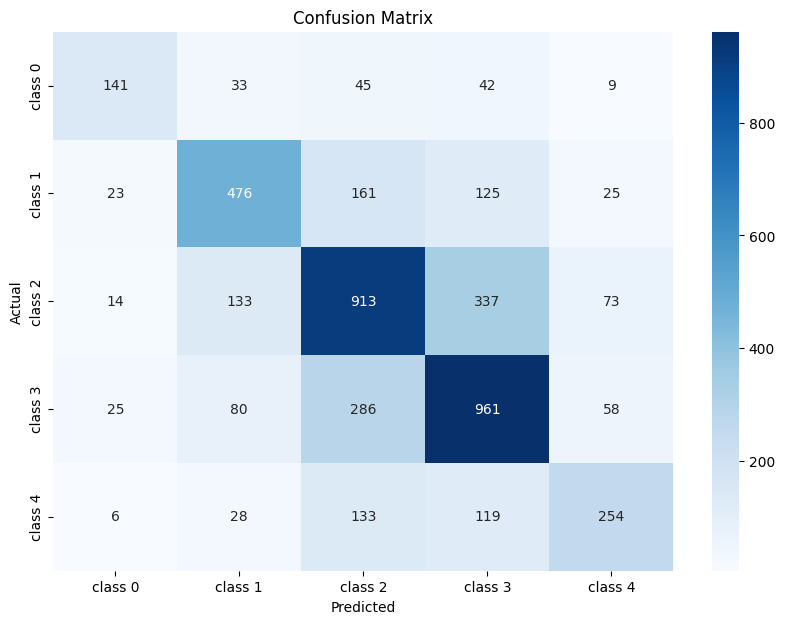

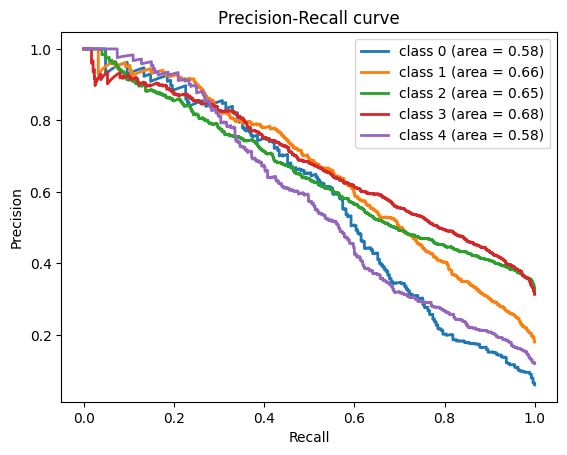

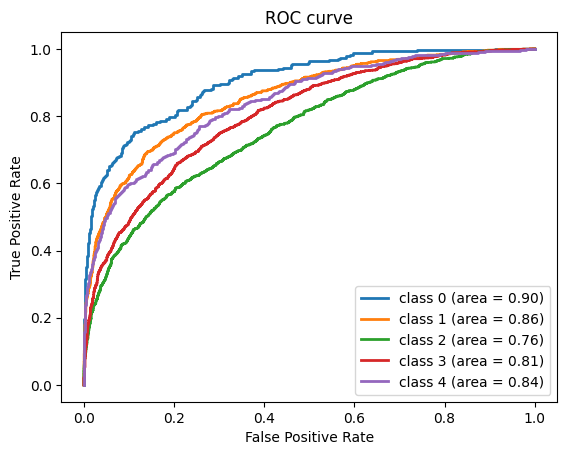

In [7]:
# 计算分类报告
report = classification_report(all_targets, all_predictions.argmax(axis=1), target_names=[f'class {i}' for i in range(5)])
print(report)

# 计算混淆矩阵
conf_matrix = confusion_matrix(all_targets, all_predictions.argmax(axis=1))

# 绘制混淆矩阵
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[f'class {i}' for i in range(5)], yticklabels=[f'class {i}' for i in range(5)])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 计算并绘制 Precision-Recall 曲线和 ROC 曲线
precision = {}
recall = {}
pr_auc = {}
fpr = {}
tpr = {}
roc_auc = {}

for i in range(5):
    precision[i], recall[i], _ = precision_recall_curve(all_targets == i, all_predictions[:, i])
    pr_auc[i] = auc(recall[i], precision[i])
    fpr[i], tpr[i], _ = roc_curve(all_targets == i, all_predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 绘制 Precision-Recall 曲线
plt.figure()
for i in range(5):
    plt.plot(recall[i], precision[i], lw=2, label=f'class {i} (area = {pr_auc[i]:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='best')
plt.show()

# 绘制 ROC 曲线
plt.figure()
for i in range(5):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'class {i} (area = {roc_auc[i]:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [8]:
# 对150个预备体进行评分
model.eval()
scores = []
with torch.no_grad():
    for i in range(len(dataset)):
        inputs, _ = dataset[i]  # 忽略目标评分，只取输入数据
        inputs = inputs.unsqueeze(0)  # 添加批次维度
        output = model(inputs)
        predicted_class = torch.argmax(output, dim=1).item() + 1
        scores.append(predicted_class)

# 输出150个预备体的评分
_, Real_Scores = read_scores(score_file_path)
Err_total = 0
for i, score in enumerate(scores):
    Err_total += abs(score-Real_Scores[i]-1)
    print(f'Tooth {i+1}: Score = {score}', f'Err = {score-Real_Scores[i]-1}' )

Tooth 1: Score = 4 Err = 0
Tooth 2: Score = 4 Err = 0
Tooth 3: Score = 3 Err = 0
Tooth 4: Score = 4 Err = 0
Tooth 5: Score = 4 Err = 0
Tooth 6: Score = 3 Err = 0
Tooth 7: Score = 4 Err = 0
Tooth 8: Score = 4 Err = 0
Tooth 9: Score = 4 Err = 0
Tooth 10: Score = 4 Err = 0
Tooth 11: Score = 4 Err = 3
Tooth 12: Score = 3 Err = 0
Tooth 13: Score = 3 Err = 0
Tooth 14: Score = 3 Err = 0
Tooth 15: Score = 3 Err = 0
Tooth 16: Score = 1 Err = 0
Tooth 17: Score = 3 Err = 0
Tooth 18: Score = 4 Err = 0
Tooth 19: Score = 3 Err = 0
Tooth 20: Score = 3 Err = 0
Tooth 21: Score = 4 Err = 0
Tooth 22: Score = 3 Err = 0
Tooth 23: Score = 4 Err = 0
Tooth 24: Score = 4 Err = 0
Tooth 25: Score = 5 Err = 0
Tooth 26: Score = 3 Err = 0
Tooth 27: Score = 4 Err = 0
Tooth 28: Score = 3 Err = 0
Tooth 29: Score = 3 Err = 0
Tooth 30: Score = 5 Err = 0
Tooth 31: Score = 3 Err = 0
Tooth 32: Score = 3 Err = 0
Tooth 33: Score = 4 Err = 0
Tooth 34: Score = 4 Err = 0
Tooth 35: Score = 3 Err = 0
Tooth 36: Score = 5 Err = 0
T